# BLDC simulation

This notebook tries to simulate a 3 phased brushless dc (BLDC) motor

References:
- http://webfiles.portal.chalmers.se/et/MSc/BaldurssonStefanMSc.pdf


# Some wild equations

Lets start with some electrical equations describing the voltage on of the 3 motor wires, a,b and c.

\begin{align}
v_a & = v_0 + e_a + R i_a + L \frac{d}{dt} i_a \\
v_b & = v_0 + e_b + R i_b + L \frac{d}{dt} i_b \\
v_c & = v_0 + e_c + R i_c + L \frac{d}{dt} i_c \\
\end{align}

Where:
- $v_a$ is the voltage on wire a
- $v_b$ is the voltage on wire b
- $v_c$ is the voltage on wire c
- $v_n$ is the inner neutral voltage, where the 3 phases meet
- $i_a$ is the current into wire a
- $i_b$ is the current into wire b
- $i_c$ is the current into wire c
- $R$ is the resistance of one phase
- $L$ is the inducate of one phase
- $e_a$ is the back-emf generated on wire a by the motor
- $e_b$ is the back-emf generated on wire b by the motor
- $e_c$ is the back-emf generated on wire c by the motor

Lets now eliminate ${v_n}$

\begin{align}
v_a - v_b & = R(i_a - i_b) + L \frac{d}{dt} (i_a - i_b) + e_a - e_b \\
v_b - v_c & = R(i_b - i_c) + L \frac{d}{dt} (i_b - i_c) + e_b - e_c \\
v_c - v_a & = R(i_c - i_a) + L \frac{d}{dt} (i_c - i_a) + e_c - e_a \\
\end{align}

Also, note that due to what comes in, must go out, we have:

\begin{align}
i_a + i_b + i_c & = 0
\end{align}

For simulation purpose, we require to isolate $\frac{d}{dt} i_a$ and $\frac{d}{dt} i_b$.

In [48]:
import sympy
from sympy import Eq, init_printing, Function, diff, solve, simplify
init_printing()

In [49]:
L, R, J, t = sympy.symbols(('L', 'R', 'J', 't'))
i_a = Function('i_a')(t)
i_b = Function('i_b')(t)
i_c = Function('i_c')(t)
# di_a, di_b, di_c = sympy.symbols(('di_a', 'di_b', 'di_c'))
v_a, v_b, v_c = sympy.symbols(('v_a', 'v_b', 'v_c'))
e_a, e_b, e_c = sympy.symbols(('e_a', 'e_b', 'e_c'))
T_e, T_a, T_b, T_c = sympy.symbols(('T_e', 'T_a', 'T_b', 'T_c'))
theta, beta = sympy.symbols(('theta', 'beta'))
di_a = diff(i_a, t)
di_b = diff(i_b, t)
di_c = diff(i_c, t)

eq1: Eq(v_a - v_b, L*(Derivative(i_a(t), t) - Derivative(i_b(t), t)) + R*(i_a(t) - i_b(t)) + e_a - e_b)
Eq(v_b - v_c, L*(Derivative(i_b(t), t) - Derivative(i_c(t), t)) + R*(i_b(t) - i_c(t)) + e_b - e_c)
Eq(-v_a + v_c, L*(-Derivative(i_a(t), t) + Derivative(i_c(t), t)) + R*(-i_a(t) + i_c(t)) - e_a + e_c)
Eq(i_a(t) + i_b(t) + i_c(t), 0)
Eq(v_b - v_c, L*(Derivative(i_a(t), t) + 2*Derivative(i_b(t), t)) + R*(i_a(t) + 2*i_b(t)) + e_b - e_c)


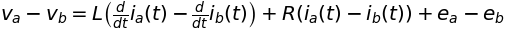

In [50]:
eq1 = Eq(v_a - v_b, R * (i_a - i_b) + L * diff(i_a - i_b, t) + e_a - e_b)
eq2 = Eq(v_b - v_c, R * (i_b - i_c) + L * diff(i_b - i_c, t) + e_b - e_c)
eq3 = Eq(v_c - v_a, R * (i_c - i_a) + L * diff(i_c - i_a, t) + e_c - e_a)
eq4 = Eq(i_a + i_b + i_c, 0)
eq7 = Eq(v_b - v_c, R * (i_a + 2*i_b) + L * diff(i_a + 2*i_b, t) + e_b - e_c)
print('eq1:', eq1)
print(eq2)
print(eq3)
print(eq4)
print(eq7)
eq1

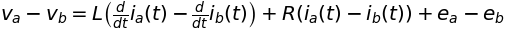

In [51]:
eq1

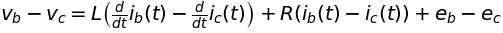

In [52]:
eq2

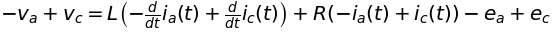

In [53]:
eq3

Eq(v_b - v_c, L*(Derivative(i_b(t), t) - Derivative(i_c(t), t)) + R*(i_b(t) - i_c(t)) + e_b - e_c)
Eq(v_b - v_c, L*(-Derivative(-i_a(t) - i_b(t), t) + Derivative(i_b(t), t)) + R*(i_a(t) + 2*i_b(t)) + e_b - e_c)


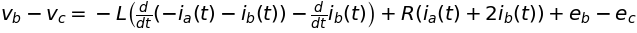

In [54]:
x = solve(eq4, i_c)[0]
eq5 = eq2.subs(i_c, x)
print(eq2)
print(eq5)
simplify(eq5)

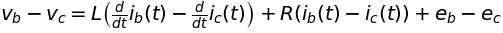

In [55]:
eq2

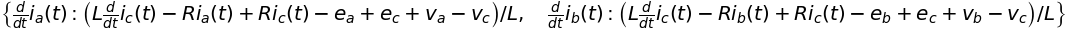

In [56]:
solve([eq1, eq2, eq3], [di_a, di_b, di_c])

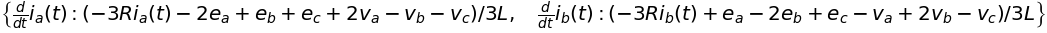

In [57]:
solve([eq1, eq7], [di_a, di_b])

# Now what?

Now we have $\frac{d}{dt} i_a$ and $\frac{d}{dt} i_b$!

Let's take a look at the mechanical part and coupling.

For the motor rotor we have:

\begin{align}
T_e & = \beta \omega + J \frac{d}{dt} \omega + T_L
\end{align}

Where:
- $T_e$ is the electrical torque
- $T_L$ is the load torque
- $J$ is the rotor inertia
- $\omega$ is the rotor velocity
- $\beta$ is the mechanical friction



In [58]:
import math

In [64]:
def F(angle):
    # Plugin here trapeziodal or sine function:
    return math.sin(angle)

def bldc(y, t):
    # Parameters:
    P = 2  # Poles
    L = 0.143e-3  # phase inductance (H)
    R = 1.27  # phase resistance (ohm)
    beta = 0.0001  # Mechanical friction
    J = 0.000001  # Mechanical rotational inertia
    k_e = 0.01  # back emf constant
    k_t = k_e  # Motor constant

    # Phase locations:
    phase_a = 0
    phase_b = -(math.pi * 2)/3
    phase_c = -(math.pi * 4)/3
    
    # Inputs:
    # Generate a sine wave:
    control_freq = 4
    control_phase = 2 * math.pi * control_freq * t
    v_a = 15*math.sin(control_phase + phase_a)
    v_b = 15*math.sin(control_phase + phase_b)
    v_c = 15*math.sin(control_phase + phase_c)
    
    # States:
    i_a = y[0]
    i_b = y[1]
    # i_c = 0  # derived from a and b
    omega_m = y[2]  # mechanical speed
    theta_m = y[3]  # mechanical angle
    
    # Calculate derived symbols:
    i_c = -(i_a + i_b)

    # Electrical angle depends on number of poles:
    theta_e = theta_m * (P / 2)

    # Forward torque from all phase currents:
    T_a = k_t * i_a * F(theta_e + phase_a)
    T_b = k_t * i_b * F(theta_e + phase_b)
    T_c = k_t * i_c * F(theta_e + phase_c)
    T_e = T_a + T_b + T_c

    # back emf:
    e_a = k_e * omega_m * F(theta_e + phase_a)
    e_b = k_e * omega_m * F(theta_e + phase_b)
    e_c = k_e * omega_m * F(theta_e + phase_c)

    # derivatives:
    di_a = (-3 * R * i_a - 2 * e_a + e_b + e_c + 2 * v_a - v_b - v_c) / (3 * L)
    di_b = (-3 * R * i_b + e_a - 2 * e_b + e_c - v_a + 2 * v_b - v_c) / (3 * L)
    dtheta_m = omega_m
    domega_m = -(beta/J) * omega_m + (1/J) * T_e
    dy = [di_a, di_b, domega_m, dtheta_m]
    
    # Update states (RK4, euler)?:
    i_a += di_a
    i_b += di_b
    theta_m += dtheta_m
    omega_m += domega_m
    return dy


bldc([0,0,0,0], 0)

In [65]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

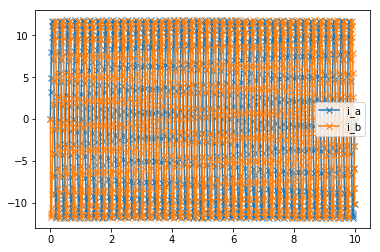

In [66]:
t = np.linspace(0, 10, 1000)
sol = odeint(bldc, [0, 0, 0, 0], t)
plt.plot(t, sol[:,0], 'x-', label='i_a')
plt.plot(t, sol[:,1], 'x-', label='i_b')
plt.legend()

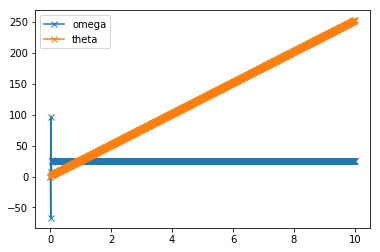

In [67]:
plt.plot(t, sol[:,2], 'x-', label='omega')
plt.plot(t, sol[:,3], 'x-', label='theta')
plt.legend()

In [63]:
sol

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 6.62223469e-01, -1.02263698e+01, -1.05043196e+02,
         2.08724924e+00],
       [-5.73482010e-01, -9.90233805e+00,  7.28545954e+01,
         1.49952772e+00],
       ...,
       [ 3.86634426e-10, -1.02286465e+01, -6.11260579e-09,
         1.57079633e+00],
       [ 1.89892620e-09, -1.02286465e+01, -5.47476244e-09,
         1.57079633e+00],
       [ 1.91829002e-11, -1.02286465e+01,  2.01115726e-08,
         1.57079633e+00]])